In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

# constants
IN_CHANNELS = 2
OUT_CHANNELS = IN_CHANNELS
AE_LEARNING_RATE = 0.0001
BATCH_SIZE = 4
AE_EPOCHS = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Imported')
print('Used device:', device)

Imported
Used device: cuda


### Data preprocessing

In [2]:
class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, *data):
        self.data = data

    def __len__(self):
        return self.data[-1].__len__()

    def __getitem__(self, index):
        return [d[index] for d in self.data]
    
# loading dataset
data = np.load('./data/brats_3d_dataset.npy')
flair, t1ce, mask = data[:, 0, None, ...], data[:, 1, None, ...], data[:, 2, None, ...]

# normalizing the data
n_max_flair = [flair[i].max() for i in range(flair.shape[0])]
n_max_t1ce = [t1ce[i].max() for i in range(t1ce.shape[0])]

for idx in range(0, flair.shape[0]):
    flair[idx] = (flair[idx] / n_max_flair[idx]).astype(np.float32)
    t1ce[idx] = (t1ce[idx] / n_max_t1ce[idx]).astype(np.float32)

# going from 0, 1 to -1, 1
flair = flair * 2 - 1
t1ce = t1ce * 2 - 1

# dataset and dataloader
train_dataset = IdentityDataset(flair, t1ce, mask)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=8, pin_memory=True
)

### Training reconstruction model

Model size: 364.90 mo


Epoch: 1/200 | Loss: nan:   2%|▏         | 3/125 [00:20<13:44,  6.76s/it]
Epoch: 1/200 | Loss: 0.0509: 100%|██████████| 125/125 [02:22<00:00,  1.14s/it]
Epoch: 2/200 | Loss: 0.0165: 100%|██████████| 125/125 [02:30<00:00,  1.21s/it]
Epoch: 3/200 | Loss: 0.0151: 100%|██████████| 125/125 [02:32<00:00,  1.22s/it]
Epoch: 4/200 | Loss: 0.0133: 100%|██████████| 125/125 [02:31<00:00,  1.21s/it]

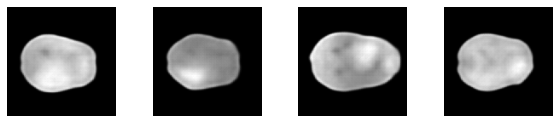

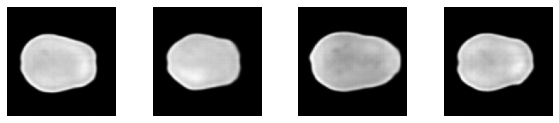

Epoch: 4/200 | Loss: 0.0133: 100%|██████████| 125/125 [02:32<00:00,  1.22s/it]
Epoch: 5/200 | Loss: 0.0115: 100%|██████████| 125/125 [02:32<00:00,  1.22s/it]
Epoch: 6/200 | Loss: 0.0100: 100%|██████████| 125/125 [02:31<00:00,  1.21s/it]
Epoch: 7/200 | Loss: 0.0097: 100%|██████████| 125/125 [02:29<00:00,  1.20s/it]
Epoch: 8/200 | Loss: 0.0106: 100%|██████████| 125/125 [02:30<00:00,  1.23s/it]

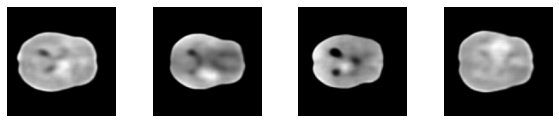

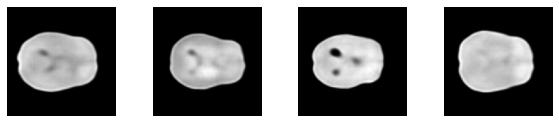

Epoch: 8/200 | Loss: 0.0106: 100%|██████████| 125/125 [02:31<00:00,  1.21s/it]
Epoch: 9/200 | Loss: 0.0093: 100%|██████████| 125/125 [02:33<00:00,  1.23s/it]
Epoch: 10/200 | Loss: 0.0090: 100%|██████████| 125/125 [02:33<00:00,  1.22s/it]
Epoch: 11/200 | Loss: 0.0089: 100%|██████████| 125/125 [02:32<00:00,  1.22s/it]
Epoch: 12/200 | Loss: 0.0096: 100%|██████████| 125/125 [02:29<00:00,  1.18s/it]

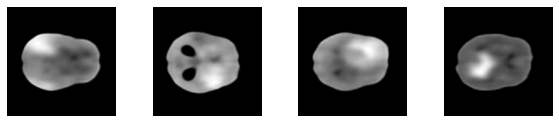

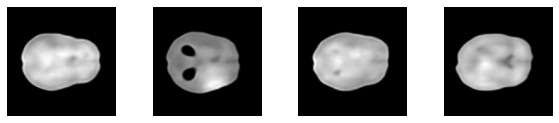

Epoch: 12/200 | Loss: 0.0096: 100%|██████████| 125/125 [02:30<00:00,  1.20s/it]
Epoch: 13/200 | Loss: 0.0085: 100%|██████████| 125/125 [02:29<00:00,  1.20s/it]
Epoch: 14/200 | Loss: 0.0085: 100%|██████████| 125/125 [02:33<00:00,  1.23s/it]
Epoch: 15/200 | Loss: 0.0083: 100%|██████████| 125/125 [02:33<00:00,  1.23s/it]
Epoch: 16/200 | Loss: 0.0083: 100%|██████████| 125/125 [02:32<00:00,  1.20s/it]

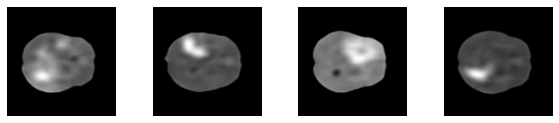

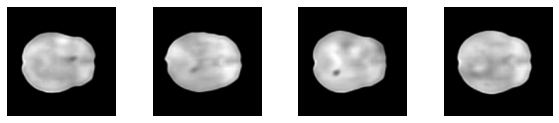

Epoch: 16/200 | Loss: 0.0083: 100%|██████████| 125/125 [02:32<00:00,  1.22s/it]
Epoch: 17/200 | Loss: 0.0082: 100%|██████████| 125/125 [02:31<00:00,  1.21s/it]
Epoch: 18/200 | Loss: 0.0083: 100%|██████████| 125/125 [02:29<00:00,  1.19s/it]
Epoch: 19/200 | Loss: 0.0080: 100%|██████████| 125/125 [02:30<00:00,  1.21s/it]
Epoch: 20/200 | Loss: 0.0078:  85%|████████▍ | 106/125 [02:09<00:23,  1.21s/it]

In [6]:
from models.autoencoder import Autoencoder

def count_params(model, verbose=False):
    total_params = sum(p.numel() for p in model.parameters())
    if verbose:
        print(f"{model.__class__.__name__} has {total_params * 1.e-6:.2f} M params.")
    return total_params

AMP = True
accumulation_steps = 1
torch.backends.cudnn.benchmark = True

autoencoder = Autoencoder(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS).to(device)
# model = torch.compile(model)

count_params(autoencoder, verbose=True)

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=AE_LEARNING_RATE, weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=train_loader.__len__() * AE_EPOCHS, eta_min=1e-9, last_epoch=-1
)

scaler = torch.cuda.amp.GradScaler(enabled=AMP)
total_loss_history = []

for epoch in range(AE_EPOCHS):
    autoencoder.train()
    optimizer.zero_grad(set_to_none=True)
    accumulated_loss = []

    progress = tqdm(train_loader, position=0, leave=True)
    for idx, (flair, t1ce, _) in enumerate(train_loader):
        B = flair.shape[0]
        flair = flair.to(device, dtype=torch.float32, non_blocking=True)
        t1ce = t1ce.to(device, dtype=torch.float32, non_blocking=True)
        # masks = masks.to(device, dtype=torch.float32, non_blocking=True)

        with torch.autocast(device.type, enabled=AMP):
            x = torch.cat([flair, t1ce], dim=1)
            x_recon = autoencoder(x)
            loss = F.l1_loss(torch.sigmoid(x_recon), x)

        scaler.scale(loss).backward()
        if (idx + 1) % accumulation_steps == 0 or (idx + 1) == len(train_loader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)

            accumulated_loss.append(loss.item())

            with torch.no_grad():
                progress.update(accumulation_steps)
                progress.set_description(f"Epoch: {epoch + 1}/{AE_EPOCHS} | Loss: {np.mean(accumulated_loss):.4f}")

    total_loss_history.append(np.mean(accumulated_loss))

    n_sample = BATCH_SIZE if BATCH_SIZE < 5 else 5
    if (epoch + 1) % 4 == 0:
        for c in range(IN_CHANNELS):
            with torch.no_grad():
                plt.figure(figsize=(10, 2))
                for i in range(n_sample):
                    plt.subplot(1, n_sample, i + 1)
                    plt.imshow(torch.sigmoid(x_recon[i, c, :, :, 32]).cpu().numpy(), cmap='gray')
                    plt.axis('off')
                plt.show()


In [5]:
import torch
from models.gaussian_autoencoder import Encoder, Decoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

e = Encoder(in_channels=1, num_channels=128, z_channels=4, z_double=False, attn=[False, False, False, True]).to(device)
d = Decoder(out_channels=1, z_channels=4, num_channels=128).to(device)

x = torch.randn(1, 1, 128, 128).to(device)

e(x).shape

torch.Size([1, 4, 8, 8])

In [6]:
e

Encoder(
  (in_conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (enocoder): ModuleList(
    (0): EncodingBlock(
      (resnet): ModuleList(
        (0): ResidualBlock(
          (temb_proj): Identity()
          (block_a): ConvBlock(
            (conv): WeightStandardizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
            (act): SiLU()
          )
          (block_b): ConvBlock(
            (conv): WeightStandardizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
            (act): SiLU()
          )
          (residual_proj): Identity()
        )
        (1): ResidualBlock(
          (temb_proj): Identity()
          (block_a): ConvBlock(
            (conv): WeightStandardizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(8, 128, eps=1e-05, a